# Clase 2. Red neuronal vectorizada Mini Batch con numpy
## Versión 2. "keritas" 

Lo mismo que el notebook anterior, pero intentando aproximarse más a un modelo inspirado en el que usa Keras.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
#from numpy.random import MT19937
#from numpy.random import RandomState, SeedSequence
#rs = RandomState(MT19937(SeedSequence(123456789)))

Función de activación Sigmoid.

In [2]:
class ActivationFunction:
    def __init__(self):
        pass
    
    def __call__(self, x):
        return NotImplemented
    
class Sigmoid(ActivationFunction):
    def __init__(self):
        ActivationFunction.__init__(self)
            
    def __call__(self, x):
        return 1 / (1 + np.exp(-x))

Métricas

In [3]:
class Metric(object):
    def __call__(self, target, prediction):
        return NotImplemented

class MSE(Metric):
    def __init__(self):
        Metric.__init__(self)

    def __call__(self, target, prediction):
        n = target.size
        return np.sum((target - prediction) ** 2) / n

Clases para Definición de modelos secuenciales por Capas estilo Keras.

In [4]:
class Layer:
    def __init__(self):
        pass
    
    def forward(self):
        raise  NotImplementedError
        
    def backward(self):
        raise  NotImplementedError
        
    def update_parameters(self):
        raise  NotImplementedError
        
class FullyConnected(Layer):
    def __init__(self,n_inputs, n_neurons,activation_fn=Sigmoid()):        
        Layer.__init__(self)
        self.W = np.random.rand(n_inputs, n_neurons)
        self.b = np.random.rand(n_neurons, 1)
        self.g = activation_fn
        
    def forward(self,a_prev):
        z = self.W.T@a_prev + self.b
        a = self.g(z)    
        return z,a
        
    def backward(self, W_next, dZ_next, z, a_next,batch_size):
        dZ = np.multiply(W_next@dZ_next,self.g(z)*(1-self.g(z)))
        dW = (1/batch_size)*(dZ@a_next.T)
        db = (1/batch_size)*np.sum(dZ,axis=1,keepdims=True)
        return dZ,dW,db
        
    def update_parameters(self,W, b):
        self.W = W
        self.b = b
        
class BinaryOutput(Layer):
    def __init__(self,n_inputs):
        Layer.__init__(self)
        self.W = np.random.rand(n_inputs, 1)
        self.b = np.random.rand(1, 1)
        self.g = Sigmoid()
        
    def forward(self,a_prev):
        z = self.W.T@a_prev + self.b
        a = self.g(z)   
        return z,a
        
    def backward(self, y_hat, y_target,z,a_prev,batch_size):
        dZ = -2*(y_target-y_hat)* (self.g(z)*(1-self.g(z)))
        dW = (1/batch_size)*(dZ@a_prev.T)
        db = (1/batch_size)*np.sum(dZ,axis=1,keepdims=True)
        return dZ,dW,db
        
    def update_parameters(self,W,b):
        self.W = W
        self.b = b        
    
class SequentialModel:
    def __init__(self):
        self.layers = []
        pass
    
    def add_layer(self,layer):
        self.layers.append(layer)    
    
    def predict(self,X):
        a_prev = X.T
        for layer in self.layers:
            z,a = layer.forward(a_prev)
            a_prev = a
        y_hat = a_prev
        return y_hat.T
    

Optimizador gradiente descendente.

In [5]:
class MiniBatchGDOptimizer:
    def __init__(self):
        pass
    
    def train(self, seqmodel ,X_train, y_train, lr=0.01, amt_epochs=1,batch_size=32, callbacks={}):
        n = X_train.shape[0] # number of samples
        m = X_train.shape[1] # number of features     
                        
        train_history = []        
        for i in range(amt_epochs):
            idx = np.random.permutation(X_train.shape[0])
            X_train = X_train[idx]
            y_train = y_train[idx]
            
            epoch_average_loss = 0
            for i in range(0, len(X_train), batch_size):            
                end = i + batch_size if i + batch_size <= len(X_train) else len(X_train)                
                batch_X = X_train[i: end]
                batch_y = y_train[i: end]        
                batch_loss = callbacks["on_batch"](batch_X,batch_y,seqmodel,lr)
                epoch_average_loss += np.sum(batch_loss)
                
            epoch_average_loss = epoch_average_loss / len(X_train)
            train_history.append(epoch_average_loss)
        
        return np.array(train_history)
    
def on_batch(X,y,seqmodel,lr):    
    batch_size = X.shape[0]
    num_features = X.shape[1]
    X_input = X.T
    y_target = y.T
    layers = seqmodel.layers
    
    cache = {}
    params = {}
    
    for layer_idx in range(len(layers)):
        params["W"+str(layer_idx+1)] = layers[layer_idx].W
        params["b"+str(layer_idx+1)] = layers[layer_idx].b
        
    # 1) Forward pass and compute error
    a_prev = X_input
    for layer_idx in range(len(layers)):
        z,a = layers[layer_idx].forward(a_prev)
        cache["z"+str(layer_idx+1)] = z
        cache["a"+str(layer_idx+1)] = a
        a_prev = a
    y_hat = a_prev
    j = (y_target-y_hat)**2
        
    # 2) Backward Pass
    last_layer = len(layers) -1
    dZ,dW,db = layers[last_layer].backward(
        y_hat, y_target,
        cache["z"+str(last_layer+1)],
        cache["a"+str(last_layer)],batch_size)
    cache["dZ"+str(last_layer+1)] = dZ
    cache["dW"+str(last_layer+1)] = dW
    cache["db"+str(last_layer+1)] = db
            
    for layer_idx in range(len(layers)-2,-1,-1):
        dZ,dW,db = layers[layer_idx].backward(
            params["W"+str(layer_idx+2)], 
            cache["dZ"+str(layer_idx+2)], 
            cache["z"+str(layer_idx+1)], 
            cache["a"+str(layer_idx+2)], 
            batch_size)
        cache["dZ"+str(layer_idx+1)] = dZ
        cache["dW"+str(layer_idx+1)] = dW
        cache["db"+str(layer_idx+1)] = db
        
    # 3) Update parameters
    for layer_idx in range(len(layers)):        
        layers[layer_idx].update_parameters(
            layers[layer_idx].W - lr*cache["dW"+str(layer_idx+1)].T,
            layers[layer_idx].b - lr*cache["db"+str(layer_idx+1)] )
        params["W"+str(layer_idx+1)] = layers[layer_idx].W
        params["b"+str(layer_idx+1)] = layers[layer_idx].b
    
    return j



## Prueba de 'keritas'

Carga del Dataset.

In [6]:
TRAIN_DATASET_FILENAME = "data/clase_2_train_data.csv"
TEST_DATASET_FILENAME = "data/clase_2_test_data.csv"

In [7]:
train_ds = np.genfromtxt(TRAIN_DATASET_FILENAME, skip_header=True, delimiter=',')
X_train = train_ds[:,0:2]
y_train = train_ds[:,2:]
X_train.shape, y_train.shape

((900, 2), (900, 1))

In [8]:
test_ds = np.genfromtxt(TRAIN_DATASET_FILENAME, skip_header=True, delimiter=',')
X_test = test_ds[:,0:2]
y_test = test_ds[:,2:]
X_test.shape, y_test.shape

((900, 2), (900, 1))

Definición del modelo secuencial por capas.

In [9]:
# Model definition
INPUT_LAYER_N_FEAT = 2
LAYER_1_N_INPUTS = INPUT_LAYER_N_FEAT 
LAYER_1_N_NEURONS = 3
LAYER_2_N_INPUTS = LAYER_1_N_NEURONS
LAYER_2_N_NEURONS = 2
OUTPUT_LAYER_N_INPUTS = LAYER_2_N_NEURONS
OUTPUT_LAYER_N_NEURONS = 1

l0 = FullyConnected(INPUT_LAYER_N_FEAT,LAYER_1_N_NEURONS)
l1 = FullyConnected(LAYER_2_N_INPUTS,LAYER_2_N_NEURONS)
l2 = BinaryOutput(OUTPUT_LAYER_N_INPUTS)

seqmodel = SequentialModel()
seqmodel.add_layer(l0)
seqmodel.add_layer(l1)
seqmodel.add_layer(l2)

Entrenamiento del modelo con optimizador MiniBatchGD.

Text(0, 0.5, 'Loss')

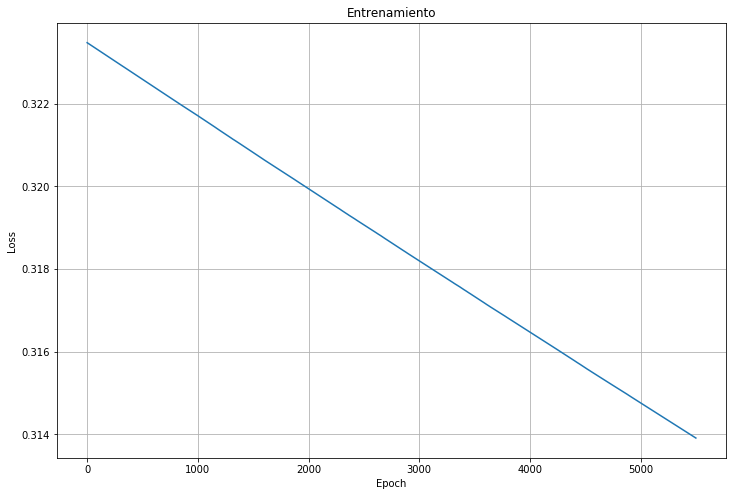

In [10]:
LEARNING_RATE = 0.00001
BATCH_SIZE = 128
N_EPOCHS = 5500

optimizer = MiniBatchGDOptimizer()
train_history = optimizer.train(seqmodel, X_train,y_train,LEARNING_RATE,N_EPOCHS,BATCH_SIZE,callbacks={ 
    "on_batch": on_batch})    

epochs = np.arange(N_EPOCHS)
plt.figure(figsize=(12,8))
plt.plot(epochs,train_history)
plt.grid(which="Both")
plt.title("Entrenamiento")
plt.xlabel("Epoch")
plt.ylabel("Loss")

### Evaluación

In [11]:
#!pip install seaborn
import sys
sys.path.append("../../intro_ai/")
from libintroia.utils import plot_confusion_matrix
from libintroia.metrics import Precision, Accuracy, Recall
metrics = [ Precision(), Accuracy(), Recall() ]

Precision: 0.49333333333333335
Accuracy: 0.49333333333333335
Recall: 1.0


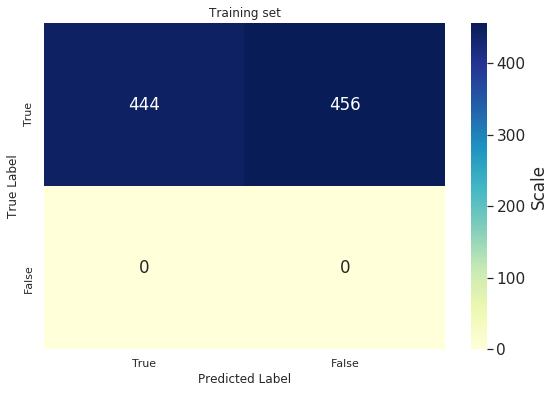

In [12]:
predicted = seqmodel.predict(X_train)
predicted[predicted<=0.5] = False
predicted[predicted>0.5] = True
actual = y_train
plot_confusion_matrix(predicted, actual, "Training set")
print("Precision:", metrics[0](actual,predicted))
print("Accuracy:", metrics[1](actual,predicted))
print("Recall:", metrics[2](actual,predicted))

Precision: 0.49333333333333335
Accuracy: 0.49333333333333335
Recall: 1.0


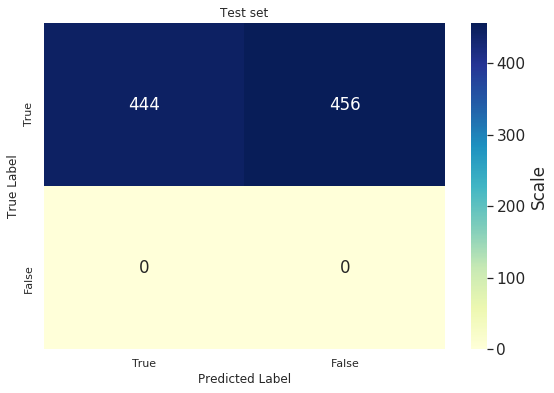

In [13]:
predicted = seqmodel.predict(X_test)
predicted[predicted<=0.5] = False
predicted[predicted>0.5] = True
actual = y_test
plot_confusion_matrix(predicted, actual, "Test set")
print("Precision:", metrics[0](actual,predicted))
print("Accuracy:", metrics[1](actual,predicted))
print("Recall:", metrics[2](actual,predicted))